<a href="https://colab.research.google.com/github/Ibrah-N/Deep-Learning-Projects-Computer-Vision/blob/main/dl_19_Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import google.colab
google.colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras

In [ ]:
# Load Mnist Dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(np.concatenate([x_train, x_test], axis=0), axis=-1).astype('float32')/255.

In [ ]:
mnist_digits.shape

(70000, 28, 28, 1)

In [ ]:
BATCH_SIZE = 128
LATTENT = 2

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)


dataset = (
    dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size=BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [ ]:
# custom vae loss

def vae_loss(y_true, y_pred, mean, log_var):
  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))
  loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + log_var  - tf.math.square(mean) - tf.math.exp(log_var)), axis=1))
  loss = loss_rec + loss_reg
  return loss

In [ ]:
# std = sqrt(var) --> sqrt(e^(log(var))) --> e^(log(var)/2)
# u = x' --> e^(log(x))

class Sampling(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(Sampling, self).__init__(**kwargs)

  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(log_var * 0.5) * tf.random.normal(shape=(BATCH_SIZE, LATTENT))

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1), name="encoder-inputs")
x = tf.keras.layers.Conv2D(filters=32, kernel_size = 3, strides=2, activation='relu', padding='same')(encoder_inputs)
x = tf.keras.layers.Conv2D(filters=64, kernel_size = 3, strides=2, activation='relu', padding='same')(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)

mean = tf.keras.layers.Dense(units=LATTENT)(x)
log_var = tf.keras.layers.Dense(units=LATTENT)(x)

z = Sampling()([mean, log_var])
encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=[z, mean, log_var], name='encoder-model')
encoder_model.summary()

Model: "encoder-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder-inputs            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ encoder-inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3136)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 16)             │         50,192 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │             34 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 2)              │             34 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (128, 2)               │              0 │ dense_5[0][0],         │
│                           │                        │                │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=(LATTENT, ), name="decoder-inputs")

x = tf.keras.layers.Dense(7*7*64, activation='relu')(decoder_inputs)
x = tf.keras.layers.Reshape(target_shape=(7, 7, 64))(x)

x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same')(x)

d_output = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation='sigmoid', padding='same')(x)
decoder_model = tf.keras.Model(inputs=decoder_inputs, outputs=d_output, name='decoder-model')
decoder_model.summary()

Model: "decoder-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder-inputs (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Variational Auto Encoder

vae_inputs = tf.keras.layers.Input(shape=(28, 28, 1), name="vae-inputs")

z, _, _ = encoder_model(vae_inputs)
reconstructed = decoder_model(z)

vae_model = tf.keras.Model(inputs=vae_inputs, outputs=reconstructed, name="vae-model")
vae_model.summary()

Model: "vae-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vae-inputs (InputLayer)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder-model (Functional)           │ [(128, 2), (None, 2),       │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder-model (Functional)           │ (128, 28, 28, 1)            │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# custom Training bloc
lr = 0.00001
EPOCHS = 20
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=lr)

def train_step(x_batch):
  with tf.GradientTape() as tape:
    z, mean, log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = vae_loss(y_true=y_true, y_pred=y_pred, mean=mean, log_var=log_var)

  partial_derivatives = tape.gradient(loss, vae_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae_model.trainable_weights))

  return loss

In [ ]:
def Ibrah(dataset, epochs):
  for epoch in range(epochs):
    print("Training : {} / {}".format((epoch+1), epochs))

    for step, x_batch in enumerate(dataset):
      loss = train_step(x_batch)
    print("Training Loss is: ", loss)

  print("Training Completed !!!!")

In [ ]:
Ibrah(dataset, EPOCHS)

Training : 1 / 20
Training Loss is:  tf.Tensor(469.79733, shape=(), dtype=float32)
Training : 2 / 20
Training Loss is:  tf.Tensor(328.61188, shape=(), dtype=float32)
Training : 3 / 20
Training Loss is:  tf.Tensor(269.1205, shape=(), dtype=float32)
Training : 4 / 20
Training Loss is:  tf.Tensor(239.16377, shape=(), dtype=float32)
Training : 5 / 20
Training Loss is:  tf.Tensor(238.87627, shape=(), dtype=float32)
Training : 6 / 20
Training Loss is:  tf.Tensor(222.67169, shape=(), dtype=float32)
Training : 7 / 20
Training Loss is:  tf.Tensor(218.54884, shape=(), dtype=float32)
Training : 8 / 20
Training Loss is:  tf.Tensor(218.82564, shape=(), dtype=float32)
Training : 9 / 20
Training Loss is:  tf.Tensor(212.26341, shape=(), dtype=float32)
Training : 10 / 20
Training Loss is:  tf.Tensor(206.67218, shape=(), dtype=float32)
Training : 11 / 20
Training Loss is:  tf.Tensor(204.85283, shape=(), dtype=float32)
Training : 12 / 20
Training Loss is:  tf.Tensor(198.52402, shape=(), dtype=float32)
Tr

In [ ]:

class vae_model_2(tf.keras.Model):
  def __init__(self, encoder=encoder_model, decoder=decoder_model, **kwargs):
    super(vae_model_2, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")


  @property
  def metrics(self):
    return [self.loss_tracker]


  def train_step(self, x_batch):
    with tf.GradientTape() as tape:
      z, mean, log_var = self.encoder(x_batch)
      y_pred = self.decoder(z)
      y_true = x_batch
      loss = vae_loss(y_true=y_true, y_pred=y_pred, mean=mean, log_var=log_var)

    partial_derivatives = tape.gradient(loss, self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

In [ ]:
vae_model_2 = vae_model_2()
vae_model_2.summary()

Model: "vae_model_2_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder-model (Functional)           │ [(128, 2), (None, 2),       │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder-model (Functional)           │ (128, 28, 28, 1)            │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae_model_2.compile(
    optimizer = OPTIMIZER,
    loss = vae_loss
)
vae_model_2.fit(dataset, epochs=EPOCHS)

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 536.8381
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 404.8147
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 305.8989
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 246.2496
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 227.8690
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 218.5377
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 211.6224
Epoch 8/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 206.3224
Epoch 9/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 202.0974
Epoch 10/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 198.8651
Epoch 11/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 196.1618
Epoch 12/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 193.9366
Epoch 13/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 191.7206
Epoch 14/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 189.6017
Epoch 15/20
546/546 ━━━━━━━━━

In [ ]:
# save model
vae_model_path = "/content/drive/MyDrive/dl_models/vae_save_model.keras"
vae_model.save(vae_model_path)

In [ ]:
scale = 1
n = 16

In [ ]:
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

print(grid_x, grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

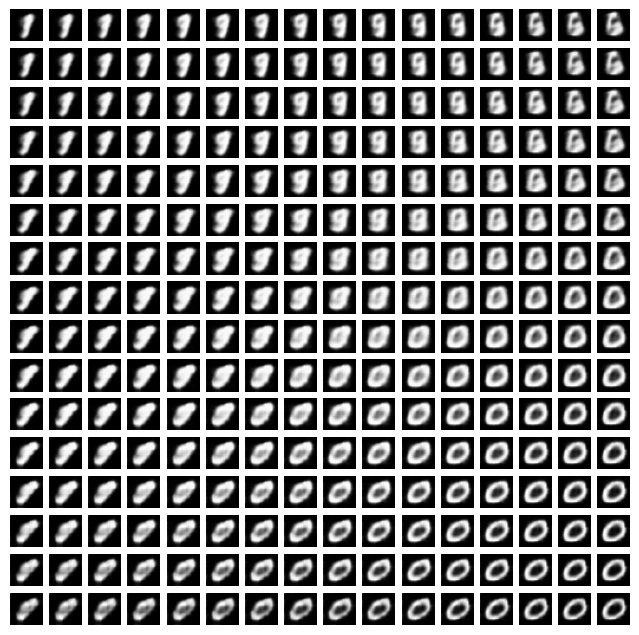

In [ ]:
# plt.figure(figsize=(8, 8))
_, ax = plt.subplots(n, n, figsize=(8, 8))

row = 0
col = 0
for i in grid_x:
  for j in grid_y:

    input = tf.constant([[i, j]])
    out = vae_model_2.get_layer("decoder-model").predict(input)[0][..., 0]
    ax[row, col].imshow(out, cmap='gray')
    ax[row, col].axis('off')

    row += 1
    if row == n:
      row = 0
      col += 1

In [ ]:
# Load Mnist Dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,  axis=-1).astype('float32')/255.
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits).batch(BATCH_SIZE, drop_remainder=True)

468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


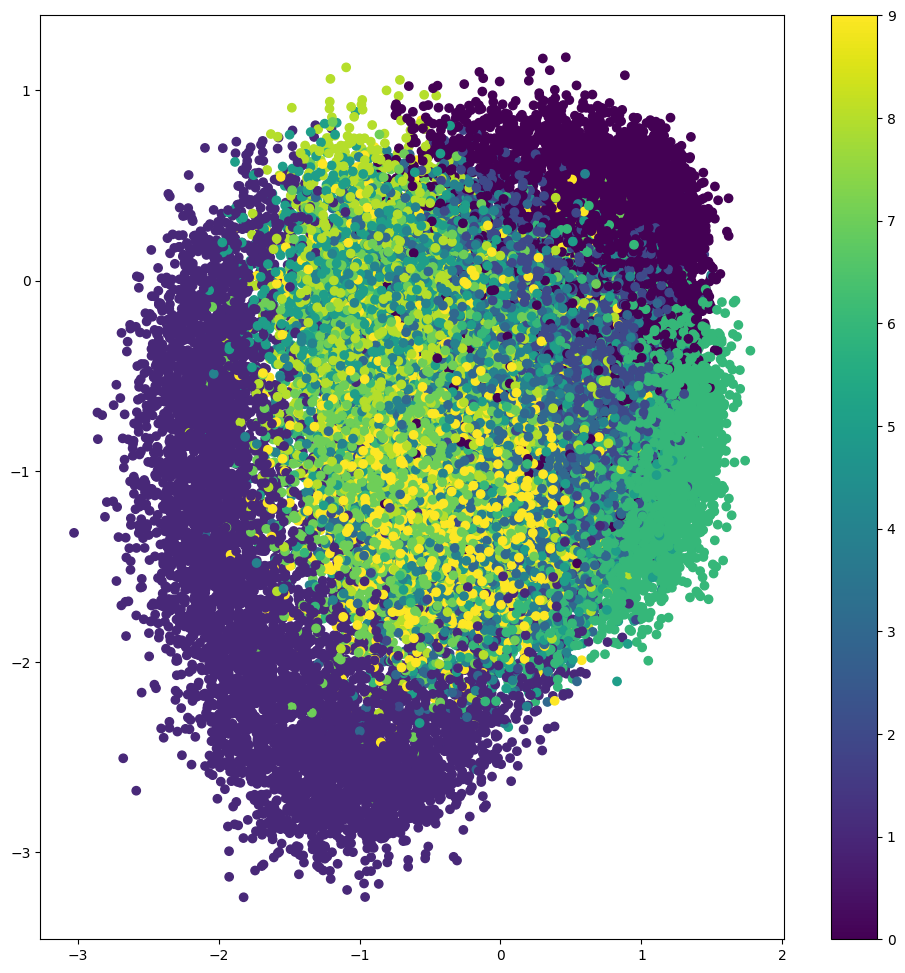

In [ ]:
z, _, _ = vae_model.get_layer("encoder-model").predict(dataset)
plt.figure(figsize=(12, 12))
plt.scatter(z[:, 0], z[:, 1], c=y_train[:-96])
plt.colorbar()